In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scipy.stats as stats

## Create the network
Load in the data and do some sanity checks that it all looks sensible, ranges, no duplicates etc

In [2]:
nodes_df = pd.read_csv('../src/traffic/data/road_network_nodes.csv')
nodes_df.describe()

node_id           x           y
count  2.380000e+02  238.000000  238.000000
mean   2.193725e+09   -0.077619   51.520893
std    1.845815e+09    0.003108    0.001161
min    1.068480e+05   -0.082885   51.519003
25%    4.702477e+08   -0.080074   51.519978
50%    1.710466e+09   -0.077881   51.520588
75%    3.197340e+09   -0.075378   51.521998
max    6.645342e+09   -0.070076   51.522963

In [3]:
edges_df = pd.read_csv('../src/traffic/data/road_network_edges.csv')
edges_df.describe()

u_id          v_id      length
count  3.130000e+02  3.130000e+02  313.000000
mean   1.524779e+09  2.648982e+09   35.512278
std    1.591060e+09  1.786882e+09   28.416675
min    1.068480e+05  1.101910e+05    2.498000
25%    2.872820e+07  1.402043e+09   12.479000
50%    1.327866e+09  2.524076e+09   29.597000
75%    2.584009e+09  4.316306e+09   49.354000
max    6.379783e+09  6.645342e+09  178.906000

Set up a graph using networkx

In [4]:
G = nx.Graph()
# add nodes
for node in nodes_df.itertuples():
    G.add_node(node.node_id, x=node.x, y=node.y)
# add edges
for edge in edges_df.itertuples():
    G.add_edge(edge.u_id, edge.v_id, length=edge.length)

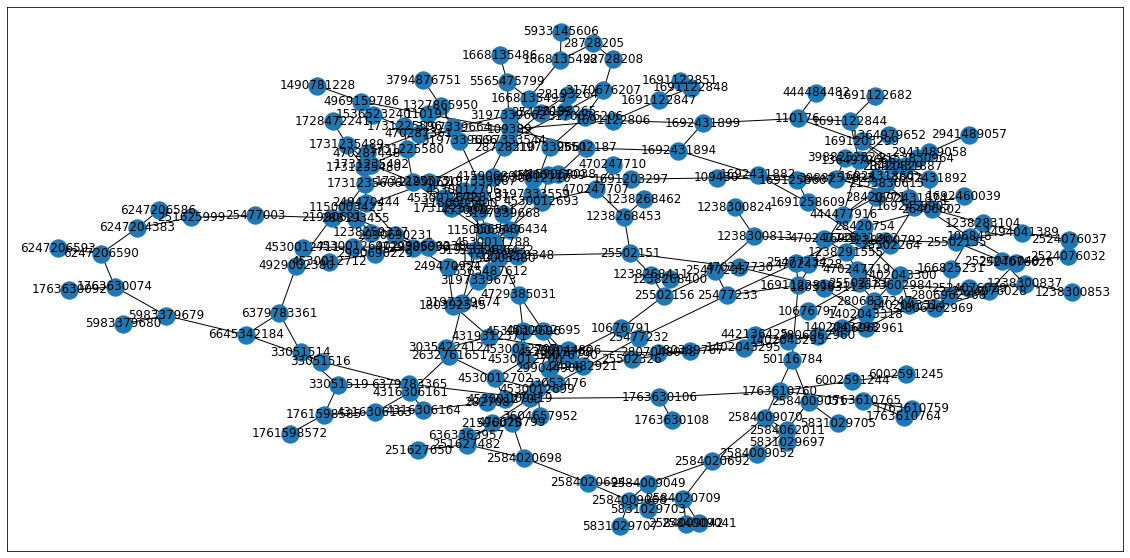

In [5]:
plt.figure(figsize=(20,10))
nx.draw_networkx(G)
plt.show()

# Investigate trips data
Load in the data and do some sanity checks that it all looks sensible, ranges, duplicates etc

In [6]:
trips_df = pd.read_csv('../src/traffic/data/trips.csv')
trips_df.describe()

origin   destination     duration
count  9.868000e+03  9.868000e+03  9868.000000
mean   2.222803e+09  2.197856e+09   574.841922
std    1.842031e+09  1.855493e+09   298.491545
min    1.068480e+05  1.068480e+05     0.000000
25%    4.702477e+08  4.702477e+08   354.630654
50%    1.731226e+09  1.692460e+09   544.166839
75%    3.197340e+09  3.197340e+09   768.741244
max    6.645342e+09  6.645342e+09  1634.129450

A trip duration of zero doesn't make too much sense. On inspection this look like trips between the same node are included. It feels sensible to remove those trips with zero trip duration for now.

In [7]:
# remove trips with zero duration
trips_df = trips_df[trips_df.duration > 0] 
trips_df.describe()

origin   destination     duration
count  9.836000e+03  9.836000e+03  9836.000000
mean   2.222567e+09  2.197539e+09   576.712087
std    1.841782e+09  1.855286e+09   297.167361
min    1.068480e+05  1.068480e+05    10.037019
25%    4.702477e+08  4.702477e+08   356.621241
50%    1.731226e+09  1.692460e+09   545.191951
75%    3.197340e+09  3.197340e+09   769.485040
max    6.645342e+09  6.645342e+09  1634.129450

**Assuming each trip is based in taking the shortest path**, we can compute the trip distance from a sum of all the edge lengths included in the shortest path. Admittedly I don't know much about the different algorithm choices here so naively using in the `shortest_path` method. 

In [8]:
def get_trip_nodes(G, origin, destination):
    path_nodes = nx.shortest_path(G, source=origin, target=destination)
    return path_nodes

In [9]:
def get_trip_distance(G, origin, destination):
    path_nodes = get_trip_nodes(G, origin, destination)
    return sum([G.edges[u, v]['length'] for u, v in zip(path_nodes[:-1], path_nodes[1:])])

In [10]:
trips_df['distance'] =[get_trip_distance(G, x.origin, x.destination) for x in trips_df.itertuples()]
trips_df['n_nodes'] = [len(get_trip_nodes(G, x.origin, x.destination)) - 2 for x in trips_df.itertuples()] # remove origin and destination nodes
trips_df.head()

origin  destination    duration  distance  n_nodes
0  2584020709   2584009051   40.790046    41.943        3
1  4159068038   1691122847  285.369605   175.999        3
2  2806962961   3197333544  848.298714   782.594       16
3    10676791   4530012706  213.849908   156.916        5
4    25477233   2990690230  390.572681   321.042        5

Whilst we are computing some attributes of each trip, let's also compute an estimate for the trip velocity (**assuming it is constant!**) and compute the number of nodes per unit distance.

In [11]:
trips_df['velocity'] = trips_df['distance']/trips_df['duration']
trips_df['nodes_per_unit_distance'] = trips_df['n_nodes'] / trips_df['distance']
trips_df.describe()

origin   destination     duration     distance      n_nodes  \
count  9.836000e+03  9.836000e+03  9836.000000  9836.000000  9836.000000   
mean   2.222567e+09  2.197539e+09   576.712087   463.599270     9.860512   
std    1.841782e+09  1.855286e+09   297.167361   244.609037     4.797650   
min    1.068480e+05  1.068480e+05    10.037019     9.840000     1.000000   
25%    4.702477e+08  4.702477e+08   356.621241   283.564500     6.000000   
50%    1.731226e+09  1.692460e+09   545.191951   435.445500    10.000000   
75%    3.197340e+09  3.197340e+09   769.485040   623.352250    13.000000   
max    6.645342e+09  6.645342e+09  1634.129450  1505.052000    26.000000   

          velocity  nodes_per_unit_distance  
count  9836.000000              9836.000000  
mean      0.818880                 0.023091  
std       0.206140                 0.009561  
min       0.345879                 0.004913  
25%       0.686705                 0.018503  
50%       0.784289                 0.021080  
75%       0.911157                 0.025006  
max       3.026392                 0.137697

The trip velocities seem quite low with a max trip velocity of ~7mph but with an average around 2mph... (**assuming SI units**) this feels a bit on the low side even for London but since the exercise hasn't specified what vehicle type I am going to go with it. To sanity check a few things, it can be useful to plot the data using the pandas `scatter_matrix`

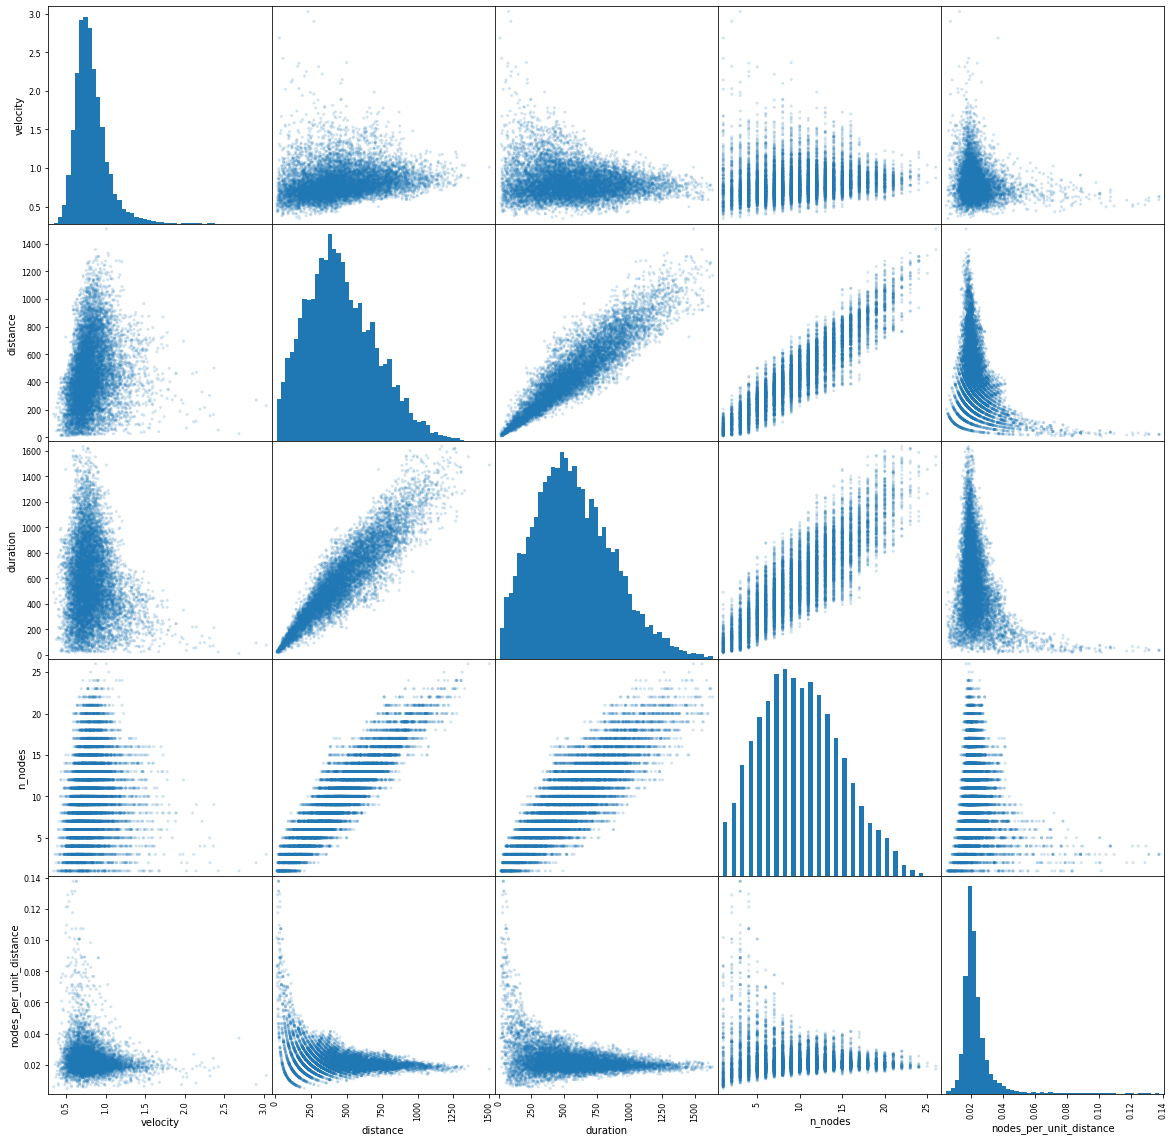

In [12]:
pd.plotting.scatter_matrix(trips_df.loc[:, ['velocity', 'distance', 'duration', 'n_nodes', 'nodes_per_unit_distance']], alpha=0.2, figsize=(20, 20), hist_kwds={'bins':50})
plt.show()

From this plot, it should be safe to assume that the data comes from a single distribution. This may not be strictly true but if there where multiple modes of operation this may indicate we need multiple models (data may have included walkers, cyclist and drivers for examples). Another observation is the distributions are non-normal (slightly skewed / truncated at zero). 

It is interesting to observe the velocity and the number of nodes per unit distance. For trips with a high density of nodes, the trip velocity tends to be low (lots of junctions, traffic lights etc). This may be a dominant factor for trips with high node density but for lower densities other factors may come into play (speed limits, road surface etc) leading to a much greater spread.

As one last sanity check, plotting the network on a map will help to ensure the trip distances computed are reasonable and to get a visual sense of scale.

In [13]:
fig = go.Figure()
traces = []
location_lookup = nodes_df.set_index('node_id').to_dict()
for edge in edges_df.itertuples():
    fig.add_trace(go.Scattermapbox(
        mode="lines",
        lon=[location_lookup['x'][edge.u_id], location_lookup['x'][edge.v_id]],
        lat=[location_lookup['y'][edge.u_id], location_lookup['y'][edge.v_id]],
        text='length: {}'.format(edge.length))
    )

fig.update_layout(mapbox=dict(style="carto-darkmatter", zoom=15, center=dict(lat=51.52 ,lon=-0.077)))
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(showlegend=False)
fig.show()

## A Naive Model

We want to predict the travel duration along each edge. To start, let's assume all computed trip velocities are possible on every edge. This is a greedy/naive approach but gives us a baseline to build on. Let's take a look at some examples...

Since the distribution of velocity is non-normal, let's see what the distribution looks like for the duration to travel a unit distance (1 meter if in SI).

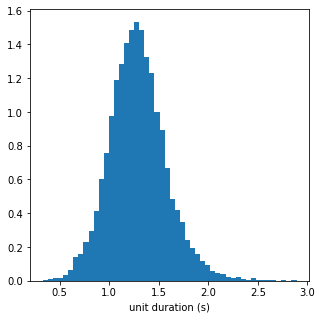

In [14]:
unit_duration = 1 / trips_df.velocity # duration to travel 1 meter
x = np.linspace(0, unit_duration.max(), 100)

plt.figure(figsize=(5,5))
plt.hist(unit_duration, bins=50, density=True)
plt.xlabel('unit duration (s)')
plt.show()

It looks reasonable to use a normal distribution here. We can simply scale this distribution based on the length of each edge.

In [15]:
naive_model_df = edges_df.copy(deep=True)
unit_duration_mean, unit_duration_std = stats.norm.fit(unit_duration)
naive_model_df['duration_mean'] = naive_model_df['length'] * unit_duration_mean
naive_model_df['duration_std'] = naive_model_df['length'] * unit_duration_std
naive_model_df.head()

u_id        v_id   length  duration_mean  duration_std
0  2524076026  2524076032    5.561       7.161373      1.593106
1  2524076032  2524076037  178.906     230.392476     51.252696
2   470287361   470287448   29.285      37.712786      8.389519
3   470287361  1536523240   19.105      24.603134      5.473169
4      109389   470287361   48.313      62.216760     13.840629

Let's do a sanity check on a random selection of edges to make sure this looks OK

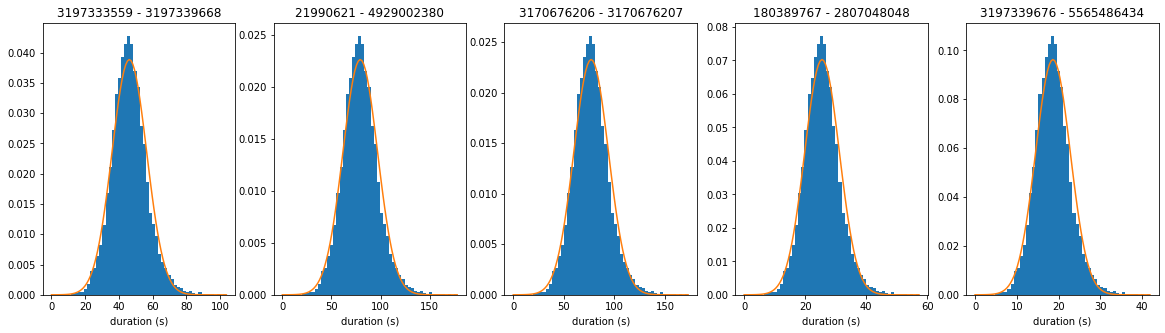

In [16]:
n_samples = 5
samples = np.random.choice(naive_model_df.index, n_samples)
plt.figure(figsize=(20,5))
for i, sample in enumerate(samples):
    plt.subplot(1, n_samples, i+1)
    greedy_duration = naive_model_df.iloc[sample]['length'] / trips_df.velocity
    plt.hist(greedy_duration, bins=50, density=True)
    x = np.linspace(0, max(greedy_duration), 100)
    plt.plot(x, stats.norm.pdf(x, naive_model_df.iloc[sample]['duration_mean'], naive_model_df.iloc[sample]['duration_std']))
    plt.xlabel('duration (s)')
    plt.title('{:.0f} - {:.0f}'.format(edges_df.iloc[sample]['u_id'], edges_df.iloc[sample]['v_id']))

Based on this prediction for the edge trip duration, let's see how well we do to reproduce the original trip data

In [17]:
naive_model_graph = nx.Graph()
for node in nodes_df.itertuples():
    naive_model_graph.add_node(node.node_id, x=node.x, y=node.y)
for edge in naive_model_df.itertuples():
    naive_model_graph.add_edge(edge.u_id, edge.v_id, length=edge.length, duration_mean=edge.duration_mean, duration_std=edge.duration_std)
    

In [18]:
def get_trip_duration_mean(G, origin, destination):
    path_nodes = nx.shortest_path(G, source=origin, target=destination)
    return sum([G.edges[u, v]['duration_mean'] for u, v in zip(path_nodes[:-1], path_nodes[1:])])

In [19]:
def get_trip_duration_std(G, origin, destination):
    path_nodes = nx.shortest_path(G, source=origin, target=destination)
    return np.sqrt(sum([G.edges[u, v]['duration_std']**2 for u, v in zip(path_nodes[:-1], path_nodes[1:])]))

In [20]:
trips_df['naive_model_duration_mean'] = [get_trip_duration_mean(naive_model_graph, x.origin, x.destination) for x in trips_df.itertuples()]
trips_df['naive_model_duration_std'] = [get_trip_duration_std(naive_model_graph, x.origin, x.destination) for x in trips_df.itertuples()]
trips_df['naive_model_error'] = trips_df['naive_model_duration_mean'] - trips_df['duration']
trips_df.head()

origin  destination    duration  distance  n_nodes  velocity  \
0  2584020709   2584009051   40.790046    41.943        3  1.028266   
1  4159068038   1691122847  285.369605   175.999        3  0.616741   
2  2806962961   3197333544  848.298714   782.594       16  0.922545   
3    10676791   4530012706  213.849908   156.916        5  0.733767   
4    25477233   2990690230  390.572681   321.042        5  0.821978   

   nodes_per_unit_distance  naive_model_duration_mean  \
0                 0.071526                  54.013569   
1                 0.017046                 226.648885   
2                 0.020445                1007.812872   
3                 0.031864                 202.074083   
4                 0.015574                 413.433096   

   naive_model_duration_std  naive_model_error  
0                  6.476049          13.223523  
1                 34.953828         -58.720720  
2                 61.340961         159.514158  
3                 25.449776         -11.775825  
4                 42.350963          22.860415

<AxesSubplot:>

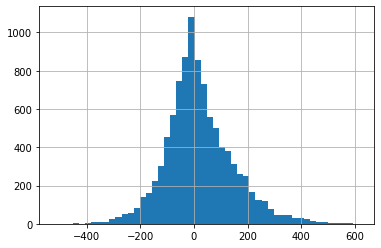

In [21]:
trips_df['naive_model_error'].hist(bins=50)

In [22]:
trips_df['naive_model_error'].abs().mean()

94.04943322089318

These residuals look OK given such a simple model... but we could clearly improve the accuracy. However the biggest limitation of this model is that it assumes each edge shares the same distribution of velocity. In practise this is a naive assumption as you can expect different edges to have different distributions.

This model maybe useful if you have no specific information about a network (it could form some prior belief about trip durations in a network with no observations) but this would limit the usefulness of the model if you wanted to find the quickest route for example. Using this model, the quickest and the shortest route are the same.

## (Slightly) Enhanced Model

In an attempt to address the limitations of the naive model, here we attempt to address this by defining a velocity distribution for each edge rather than assuming they all come from the same distribution.

We take a simple approach here by using a subset of trips to determine the velocity distribution for each edge. Note this still has a lots of limitations but should offer a small iteration of improvement over the previous model.

In [23]:
G2 = nx.Graph()
for node in nodes_df.itertuples():
    G2.add_node(node.node_id, x=node.x, y=node.y)
    
for edge in edges_df.itertuples():
    G2.add_edge(edge.u_id, edge.v_id, length=edge.length, velocity_samples=[]) # included velocity samples

In [24]:
# if the edge is in the trip, append this sample to the edge attributes
for trip in trips_df.itertuples():
    path_nodes = get_trip_nodes(G2, trip.origin, trip.destination)
    for i in range(1, len(path_nodes)):
        G2.edges[path_nodes[i-1], path_nodes[i]]['velocity_samples'].append(trip.velocity)

In [25]:
enhanced_model_df = naive_model_df.copy(deep=True)
edge_velocity_samples = nx.get_edge_attributes(G2, 'velocity_samples')
for edge in enhanced_model_df.itertuples():
    velocity_samples = G2.edges[edge.u_id, edge.v_id]['velocity_samples']
    enhanced_model_df.loc[edge.Index, 'n_samples'] = len(velocity_samples)
    if len(velocity_samples) > 100:
        enhanced_model_df.loc[edge.Index, 'duration_mean'] = edge.length * np.mean(1 / np.array(velocity_samples))
        enhanced_model_df.loc[edge.Index, 'duration_std'] = edge.length * np.std(1 / np.array(velocity_samples))

In [26]:
enhanced_model_graph = nx.Graph()
for node in nodes_df.itertuples():
    enhanced_model_graph.add_node(node.node_id, x=node.x, y=node.y)
for edge in enhanced_model_df.itertuples():
    enhanced_model_graph.add_edge(edge.u_id, edge.v_id, length=edge.length, duration_mean=edge.duration_mean, duration_std=edge.duration_std)
    

In [27]:
trips_df['enhanced_model_duration_mean'] = [get_trip_duration_mean(enhanced_model_graph, x.origin, x.destination) for x in trips_df.itertuples()]
trips_df['enhanced_model_duration_std'] = [get_trip_duration_std(enhanced_model_graph, x.origin, x.destination) for x in trips_df.itertuples()]
trips_df['enhanced_model_error'] = trips_df['enhanced_model_duration_mean'] - trips_df['duration']
trips_df.head()

origin  destination    duration  distance  n_nodes  velocity  \
0  2584020709   2584009051   40.790046    41.943        3  1.028266   
1  4159068038   1691122847  285.369605   175.999        3  0.616741   
2  2806962961   3197333544  848.298714   782.594       16  0.922545   
3    10676791   4530012706  213.849908   156.916        5  0.733767   
4    25477233   2990690230  390.572681   321.042        5  0.821978   

   nodes_per_unit_distance  naive_model_duration_mean  \
0                 0.071526                  54.013569   
1                 0.017046                 226.648885   
2                 0.020445                1007.812872   
3                 0.031864                 202.074083   
4                 0.015574                 413.433096   

   naive_model_duration_std  naive_model_error  enhanced_model_duration_mean  \
0                  6.476049          13.223523                     55.489528   
1                 34.953828         -58.720720                    230.188765   
2                 61.340961         159.514158                    980.183889   
3                 25.449776         -11.775825                    183.735725   
4                 42.350963          22.860415                    403.372811   

   enhanced_model_duration_std  enhanced_model_error  
0                     6.857221             14.699482  
1                    30.524872            -55.180840  
2                    48.417443            131.885176  
3                    21.582949            -30.114183  
4                    36.238889             12.800130

<AxesSubplot:>

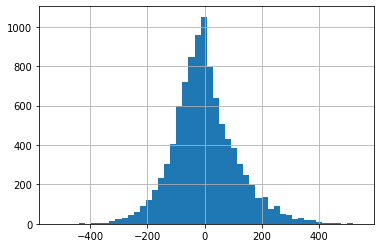

In [28]:
trips_df['enhanced_model_error'].hist(bins=50)

In [29]:
trips_df['enhanced_model_error'].abs().mean()

83.93199730511618

<AxesSubplot:ylabel='Frequency'>

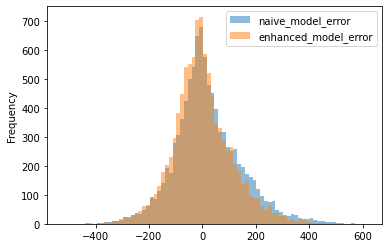

In [30]:
trips_df[['naive_model_error','enhanced_model_error']].plot.hist(alpha=0.5, bins=80)

This enhanced model only offers a small improvement over the naive approach but seems to be going in the right direction. Given more time, I would focus efforts on finding alternative approaches to determine a suitable distribution for each edge. This would benefit from additional data that characterises the attributes of each edge such as road type, speed limits, car density etc. 

A dynamic model would be most useful in practise which would require regular updates to these distributions to take into account changing traffic conditions.

## Some future notes
* Could use a Bayesian approach to infer distributions for each edge using a prior distribution and updating as data for that edge becomes available.
* Would be cool to think of some machine learning approach to predict the duration of each segment where the features include binary variables for each edge... probably need to think about this some more and may be challenging to keep a measure of uncertainty in the prediction
* Since we are comparing distribution, we can measure the reliability/robustness of our model (not just accuracy). We could consider using measures like KL divergence.